# 확산모델(Diffusion Model) 기반 대기 중 화학물질 영향 범위 분석
공간정보아카데미 공간분석 심화과정의 공간분석 모델링 중 오염물질 누출 분석 자료를 보고 만듦

In [90]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
from fiona.crs import from_epsg # 좌표변환 
import contextily as ctx
from geopy.distance import great_circle  # 거리를 계산하기 위한 라이브러리

In [2]:
#import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#sns.set_style('darkgrid') #whitegrid, dark, white, ticks
mpl.rc('font', family='NanumGothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (16,4.5) #차트 사이즈

## 누출지점 정보 생성

In [78]:
# 누출지점 정보
df_pt = pd.DataFrame(
    {'id': [1],
     'name': ['누출지점1'],
     'lat': [36.144488],
     'lon': [128.453943]})

In [79]:
# 누출지점 포인트 공간데이터 생성
gdf_pt_geom = gpd.points_from_xy(df_pt.lon, df_pt.lat)
gdf_pt4326 = gpd.GeoDataFrame(df_pt, geometry=gdf_pt_geom, crs=from_epsg(4326))
gdf_pt3857 = gdf_pt4326.to_crs(epsg=3857)
# gdf_pt3857["pt_x"] = gdf_pt3857.geometry.x
# gdf_pt3857["pt_y"] = gdf_pt3857.geometry.y

C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<ipython-input-62-e1392827542a>:3: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  ctx.add_basemap(ax, source=ctx.sources.ST_TERRAIN)  #ctx.sources.ST_TONER_LITE


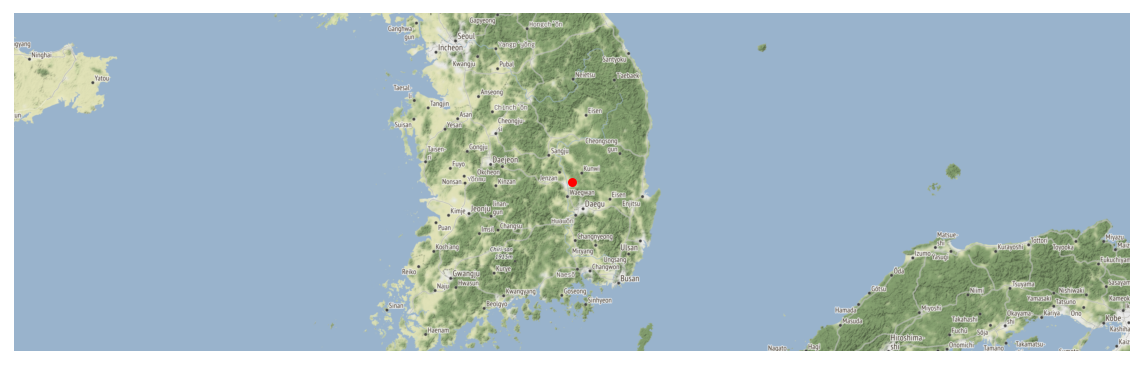

In [62]:
# 누출지점 위치
ax = gdf_pt3857.plot(markersize=12, figsize=(10, 10), color='Red')
ctx.add_basemap(ax, source=ctx.sources.ST_TERRAIN)  #ctx.sources.ST_TONER_LITE
ax.set_axis_off()
plt.show()

## 주변 격자 생성

In [215]:
# 포인트 범위에 해당하는 격자 폴리곤 생성 
from shapely.geometry import Polygon

# 범위
xmin = gdf_pt3857.geometry.x - 3000
xmax = gdf_pt3857.geometry.x + 3000
ymin = gdf_pt3857.geometry.y - 3000
ymax = gdf_pt3857.geometry.y + 3000

# 격자 크기
wide = 50
length = 50

cols = list(range(int(np.floor(xmin)), int(np.ceil(xmax)), wide))
rows = list(range(int(np.floor(ymin)), int(np.ceil(ymax)), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

grid3857 = gpd.GeoDataFrame({'geometry':polygons})
grid3857.crs="epsg:3857"

In [216]:
# 순번
grid3857['grid_id'] = grid3857.index + 1

In [217]:
grid4326 = grid3857.to_crs(epsg=4326)
grid4326["grid_lon"] = grid4326.centroid.geometry.x
grid4326["grid_lat"] = grid4326.centroid.geometry.y

<ipython-input-217-bc3bb2e6c6d6>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid4326["grid_lon"] = grid4326.centroid.geometry.x
<ipython-input-217-bc3bb2e6c6d6>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid4326["grid_lat"] = grid4326.centroid.geometry.y


C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


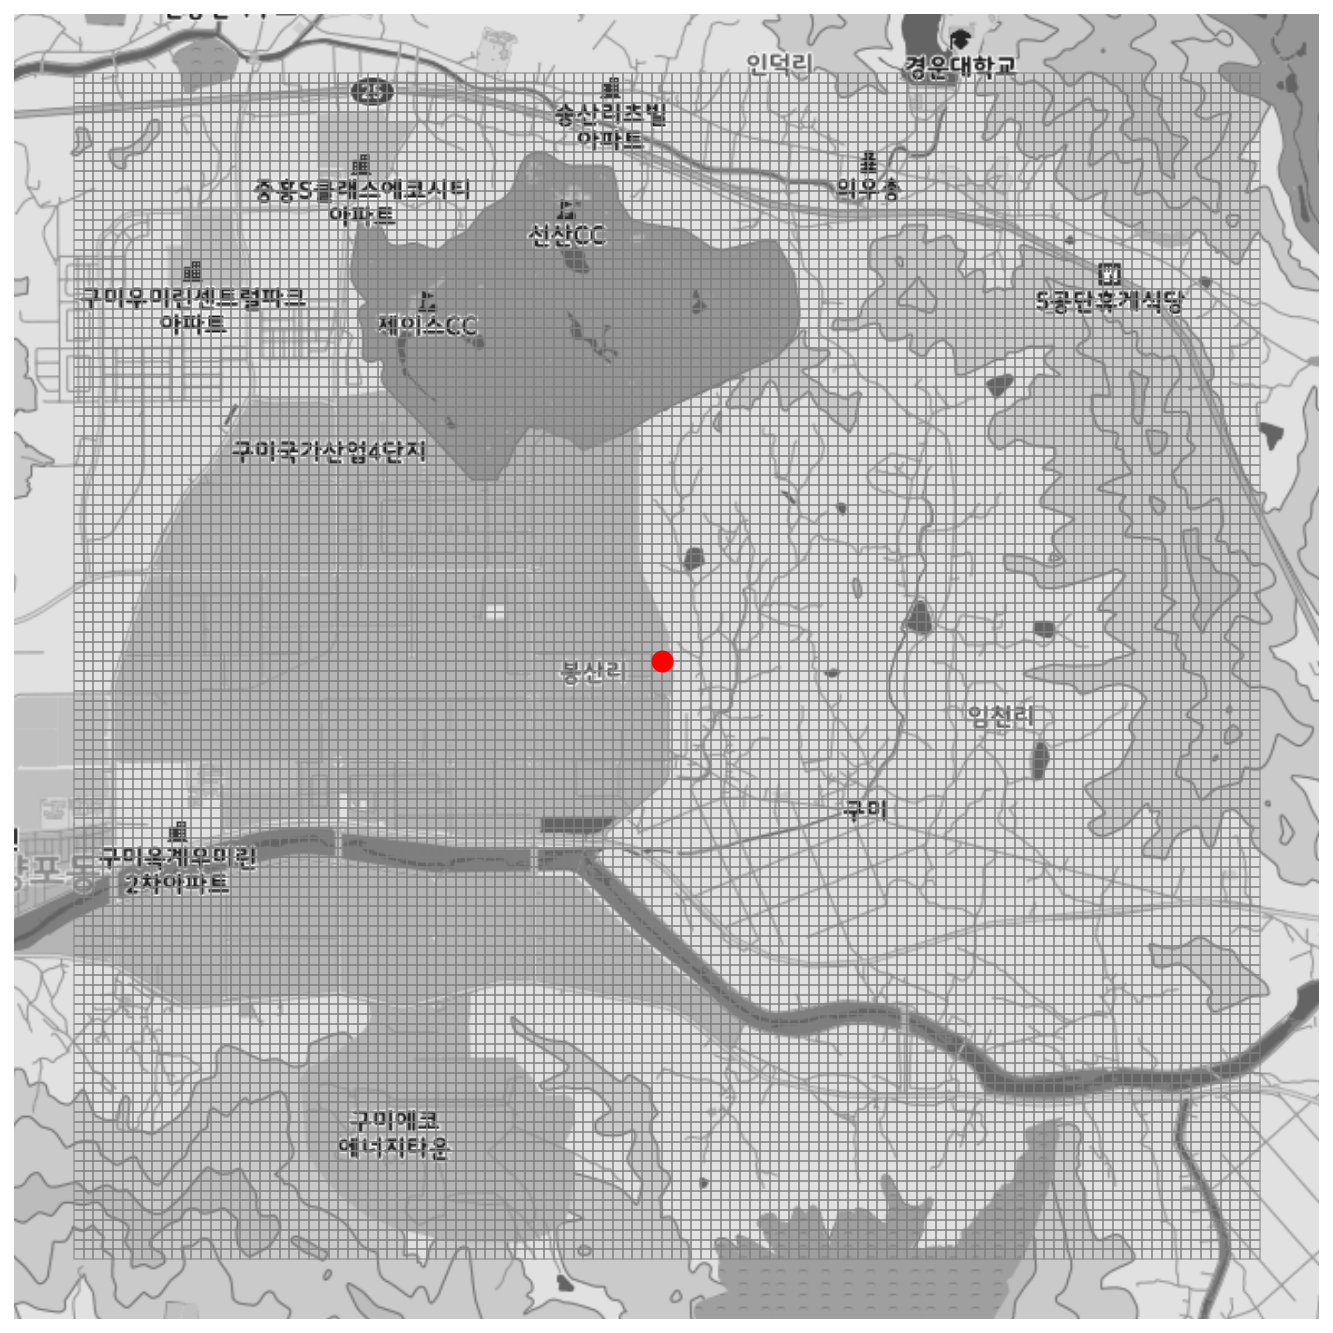

In [218]:
map_url = "http://xdworld.vworld.kr:8080/2d/gray/service/{z}/{x}/{y}.png"

ax = grid3857.plot(facecolor='none', edgecolor='gray', linewidth=1, figsize=(12, 12), alpha=0.5)
gdf_pt3857.plot(ax=ax, markersize=100, color='Red')
ctx.add_basemap(ax, source=map_url)  #ctx.sources.ST_TONER_LITE , ctx.sources.OSM_A
ax.set_axis_off()
plt.show()

In [71]:
gdf_pt3857.to_file('data/gdf_pt3857.shp', encoding='euc-kr')
grid3857.to_file('data/grid3857.shp', encoding='euc-kr')

In [219]:
# 누출 포인트를 복사하고 지오메트리 컬럼을 삭제 
gdf_pt4326_2 = gdf_pt4326.copy()
df_pt4326 = gdf_pt4326_2.drop(['geometry'], axis=1) 
df_pt4326.head()

,id,name,lat,lon
0,1,누출지점1,36.144488,128.453943


In [220]:
# cross join geopandas - 데이터가 너무 크면 문제될 수 있음 
grid4326['key'] = 1
df_pt4326['key'] = 1
merged = grid4326.merge(df_pt4326, on='key')
merged.info()
merged.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14641 entries, 0 to 14640
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  14641 non-null  geometry
 1   grid_id   14641 non-null  int64   
 2   grid_lon  14641 non-null  float64 
 3   grid_lat  14641 non-null  float64 
 4   key       14641 non-null  int64   
 5   id        14641 non-null  int64   
 6   name      14641 non-null  object  
 7   lat       14641 non-null  float64 
 8   lon       14641 non-null  float64 
dtypes: float64(4), geometry(1), int64(3), object(1)
memory usage: 1.1+ MB


,geometry,grid_id,grid_lon,grid_lat,key,id,name,lat,lon
0,"POLYGON ((128.42699 36.16624, 128.42744 36.166...",1,128.427213,36.166059,1,1,누출지점1,36.144488,128.453943
1,"POLYGON ((128.42699 36.16588, 128.42744 36.165...",2,128.427213,36.165697,1,1,누출지점1,36.144488,128.453943
2,"POLYGON ((128.42699 36.16552, 128.42744 36.165...",3,128.427213,36.165334,1,1,누출지점1,36.144488,128.453943
3,"POLYGON ((128.42699 36.16515, 128.42744 36.165...",4,128.427213,36.164971,1,1,누출지점1,36.144488,128.453943
4,"POLYGON ((128.42699 36.16479, 128.42744 36.164...",5,128.427213,36.164609,1,1,누출지점1,36.144488,128.453943


In [221]:
# 격자와 포인트간 직선거리 산출 
merged['dist'] = merged.apply(lambda x: great_circle((x['grid_lat'], x['grid_lon']), (x['lat'], x['lon'])).meters, axis=1)
merged.head()

,geometry,grid_id,grid_lon,grid_lat,key,id,name,lat,lon,dist
0,"POLYGON ((128.42699 36.16624, 128.42744 36.166...",1,128.427213,36.166059,1,1,누출지점1,36.144488,128.453943,3393.009683
1,"POLYGON ((128.42699 36.16588, 128.42744 36.165...",2,128.427213,36.165697,1,1,누출지점1,36.144488,128.453943,3364.630705
2,"POLYGON ((128.42699 36.16552, 128.42744 36.165...",3,128.427213,36.165334,1,1,누출지점1,36.144488,128.453943,3336.497486
3,"POLYGON ((128.42699 36.16515, 128.42744 36.165...",4,128.427213,36.164971,1,1,누출지점1,36.144488,128.453943,3308.616300
4,"POLYGON ((128.42699 36.16479, 128.42744 36.164...",5,128.427213,36.164609,1,1,누출지점1,36.144488,128.453943,3280.993582


In [222]:
# 격자와 노출지점간 각도
merged['angle'] = merged.apply(lambda x: math.atan2(x['grid_lat'] - x['lat'], x['grid_lon'] - x['lon']), axis=1)
# 180도 기준의 각도
#merged['angle2'] = merged.apply(lambda x: math.atan2(x['grid_lat'] - x['lat'], x['grid_lon'] - x['lon'])  * 180 / math.pi, axis=1)
#math.atan2(targetPts.y()-sourcePts.y(),targetPts.x()-sourcePts.x())
merged.head()

,geometry,grid_id,grid_lon,grid_lat,key,id,name,lat,lon,dist,angle
0,"POLYGON ((128.42699 36.16624, 128.42744 36.166...",1,128.427213,36.166059,1,1,누출지점1,36.144488,128.453943,3393.009683,2.462586
1,"POLYGON ((128.42699 36.16588, 128.42744 36.165...",2,128.427213,36.165697,1,1,누출지점1,36.144488,128.453943,3364.630705,2.470856
2,"POLYGON ((128.42699 36.16552, 128.42744 36.165...",3,128.427213,36.165334,1,1,누출지점1,36.144488,128.453943,3336.497486,2.479236
3,"POLYGON ((128.42699 36.16515, 128.42744 36.165...",4,128.427213,36.164971,1,1,누출지점1,36.144488,128.453943,3308.616300,2.487727
4,"POLYGON ((128.42699 36.16479, 128.42744 36.164...",5,128.427213,36.164609,1,1,누출지점1,36.144488,128.453943,3280.993582,2.496330


In [253]:
# 풍향
direction = -5  #북동풍이면 45, 북서풍이면 -45
direction = direction * math.pi / 180
print(direction)

-0.08726646259971647


In [254]:
# 각 셀의 누출량
a = 10000 #누출지점의 오염도 
b = 200   #거리 척도 
k = 2.5     #이심률(바람의 강도)

merged['level'] = merged.apply(lambda x: a * math.exp(-(math.pow(x['dist'] / b, 2) * math.pow(math.exp(-k * math.cos(x['angle']-direction)), 2))), axis=1)

In [243]:
merged.level.max()

9998.481620670998

In [226]:
merged.level.min()

0.0

In [185]:
merged.to_file('data/merged.shp', encoding='euc-kr')

In [255]:
merged3857 = merged.to_crs(epsg=3857)
merged3857_2 = merged3857[ merged3857.level >= merged3857.level.quantile(0.75)]

C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\dhl\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)


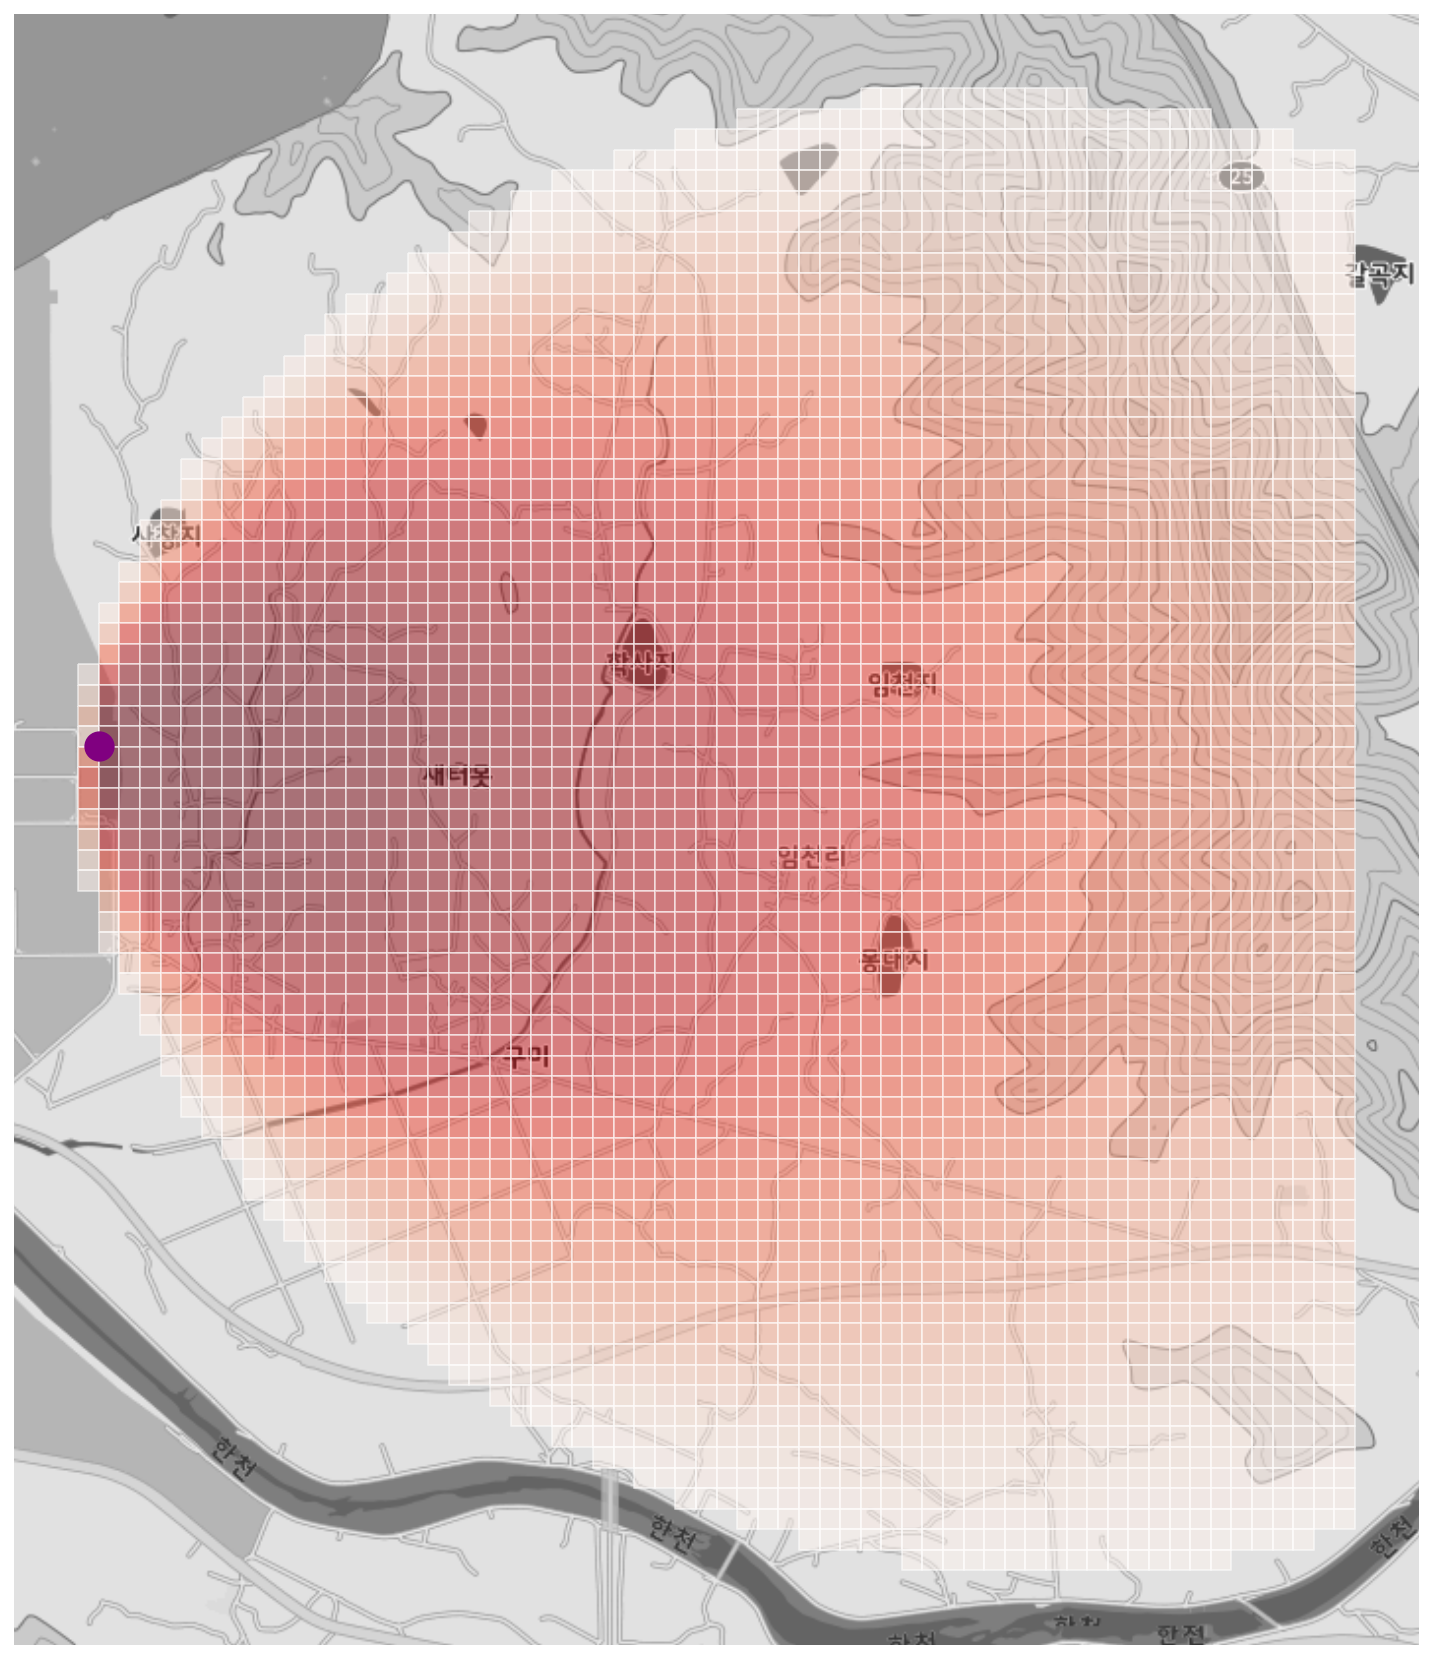

In [256]:
# 결과물 시각화
ax = merged3857_2.plot(column='level', scheme='fisherjenks', k=50, cmap='Reds', figsize=(15, 15), alpha=0.5)  
gdf_pt3857.plot(ax=ax, markersize=200, color='Purple')
ctx.add_basemap(ax, source=map_url)  #ctx.sources.ST_TONER_LITE
ax.set_axis_off()
plt.show()